## Stain Normalization


In [1]:
import math
import os
from os import listdir

import numpy as np
import cv2
import pandas as pd

from scipy.ndimage.morphology import binary_fill_holes
from skimage.color import rgb2gray
from skimage.feature import canny
import matplotlib.pyplot as plt
%matplotlib inline
image_path = "./image/"


In [2]:
def normalize_staining(sample_tuple, beta=0.15, alpha=1, light_intensity=255):
    """
    Normalize the staining of H&E histology slides.
    This function normalizes the staining of H&E histology slides.
    References:
    - Macenko, Marc, et al. "A method for normalizing histology slides
    for quantitative analysis." Biomedical Imaging: From Nano to Macro,
    2009.  ISBI'09. IEEE International Symposium on. IEEE, 2009.
      - http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf
    - https://github.com/mitkovetta/staining-normalization
    Args:
    sample_tuple: A (slide_num, sample) tuple, where slide_num is an
      integer, and sample is a 3D NumPy array of shape (H,W,C).
    Returns:
    A (slide_num, sample) tuple, where the sample is a 3D NumPy array
    of shape (H,W,C) that has been stain normalized.
    """
    # Setup.
    slide_num, sample = sample_tuple
    x = np.asarray(sample)
    h, w, c = x.shape
    x = x.reshape(-1, c).astype(np.float64)  # shape (H*W, C)

    # Reference stain vectors and stain saturations.  We will normalize all slides
    # to these references.  To create these, grab the stain vectors and stain
    # saturations from a desirable slide.

    # Values in reference implementation for use with eigendecomposition approach, natural log,
    # and `light_intensity=240`.
    #stain_ref = np.array([0.5626, 0.2159, 0.7201, 0.8012, 0.4062, 0.5581]).reshape(3,2)
    #max_sat_ref = np.array([1.9705, 1.0308]).reshape(2,1)

    # SVD w/ log10, and `light_intensity=255`.
    stain_ref = (np.array([0.54598845, 0.322116, 0.72385198, 0.76419107, 0.42182333, 0.55879629])
                 .reshape(3,2))
    max_sat_ref = np.array([0.82791151, 0.61137274]).reshape(2,1)

    # Convert RGB to OD.
    # Note: The original paper used log10, and the reference implementation used the natural log.
    #OD = -np.log((x+1)/light_intensity)  # shape (H*W, C)
    OD = -np.log10(x/light_intensity + 1e-8)

    # Remove data with OD intensity less than beta.
    # I.e. remove transparent pixels.
    # Note: This needs to be checked per channel, rather than
    # taking an average over all channels for a given pixel.
    OD_thresh = OD[np.all(OD >= beta, 1), :]  # shape (K, C)

    # Calculate eigenvectors.
    # Note: We can either use eigenvector decomposition, or SVD.
    #eigvals, eigvecs = np.linalg.eig(np.cov(OD_thresh.T))  # np.cov results in inf/nans
    U, s, V = np.linalg.svd(OD_thresh, full_matrices=False)

    # Extract two largest eigenvectors.
    # Note: We swap the sign of the eigvecs here to be consistent
    # with other implementations.  Both +/- eigvecs are valid, with
    # the same eigenvalue, so this is okay.
    #top_eigvecs = eigvecs[:, np.argsort(eigvals)[-2:]] * -1
    top_eigvecs = V[0:2, :].T * -1  # shape (C, 2)

    # Project thresholded optical density values onto plane spanned by
    # 2 largest eigenvectors.
    proj = np.dot(OD_thresh, top_eigvecs)  # shape (K, 2)

    # Calculate angle of each point wrt the first plane direction.
    # Note: the parameters are `np.arctan2(y, x)`
    angles = np.arctan2(proj[:, 1], proj[:, 0])  # shape (K,)

    # Find robust extremes (a and 100-a percentiles) of the angle.
    min_angle = np.percentile(angles, alpha)
    max_angle = np.percentile(angles, 100-alpha)

    # Convert min/max vectors (extremes) back to optimal stains in OD space.
    # This computes a set of axes for each angle onto which we can project
    # the top eigenvectors.  This assumes that the projected values have
    # been normalized to unit length.
    extreme_angles = np.array([[np.cos(min_angle), np.cos(max_angle)],[np.sin(min_angle), np.sin(max_angle)]])  # shape (2,2)
    stains = np.dot(top_eigvecs, extreme_angles)  # shape (C, 2)

    # Merge vectors with hematoxylin first, and eosin second, as a heuristic.
    if stains[0, 0] < stains[0, 1]:
        stains[:, [0, 1]] = stains[:, [1, 0]]  # swap columns

    # Calculate saturations of each stain.
    # Note: Here, we solve
    #    OD = VS
    #     S = V^{-1}OD
    # where `OD` is the matrix of optical density values of our image,
    # `V` is the matrix of stain vectors, and `S` is the matrix of stain
    # saturations.  Since this is an overdetermined system, we use the
    # least squares solver, rather than a direct solve.
    sats, _, _, _ = np.linalg.lstsq(stains, OD.T)

    # Normalize stain saturations to have same pseudo-maximum based on
    # a reference max saturation.
    max_sat = np.percentile(sats, 99, axis=1, keepdims=True)
    sats = sats / max_sat * max_sat_ref

    # Compute optimal OD values.
    OD_norm = np.dot(stain_ref, sats)

    # Recreate image.
    # Note: If the image is immediately converted to uint8 with `.astype(np.uint8)`, it will
    # not return the correct values due to the initital values being outside of [0,255].
    # To fix this, we round to the nearest integer, and then clip to [0,255], which is the
    # same behavior as Matlab.
    #x_norm = np.exp(OD_norm) * light_intensity  # natural log approach
    x_norm = 10**(-OD_norm) * light_intensity - 1e-8  # log10 approach
    x_norm = np.clip(np.round(x_norm), 0, 255).astype(np.uint8)
    x_norm = x_norm.astype(np.uint8)
    x_norm = x_norm.T.reshape(h,w,c)
    return x_norm
def subplots(prefix,filelist):
    plt.figure(figsize=(16, 12))
    ncol = 5
    nrow = math.ceil(len(filelist) // ncol)
    
    for i in range(0, len(filelist)):
        plt.subplot(nrow, ncol, i + 1)
        img = cv2.imread(os.path.join(prefix,filelist[i]))
        plt.imshow(img)
def subplots_normal(prefix,filelist):
    plt.figure(figsize=(16, 12))
    ncol = 5
    nrow = math.ceil(len(filelist) // ncol)
    
    for i in range(0, len(filelist)):
        plt.subplot(nrow, ncol, i + 1)
        img = cv2.imread(os.path.join(prefix,filelist[i]))
        img = normalize_staining((1,img))
        plt.imshow(img)
tumor_filelist = os.listdir(os.path.join(image_path,'tumor'))
normal_filelist = os.listdir(os.path.join(image_path,'normal'))
random_list = np.random.choice(tumor_filelist,20)

## Origin

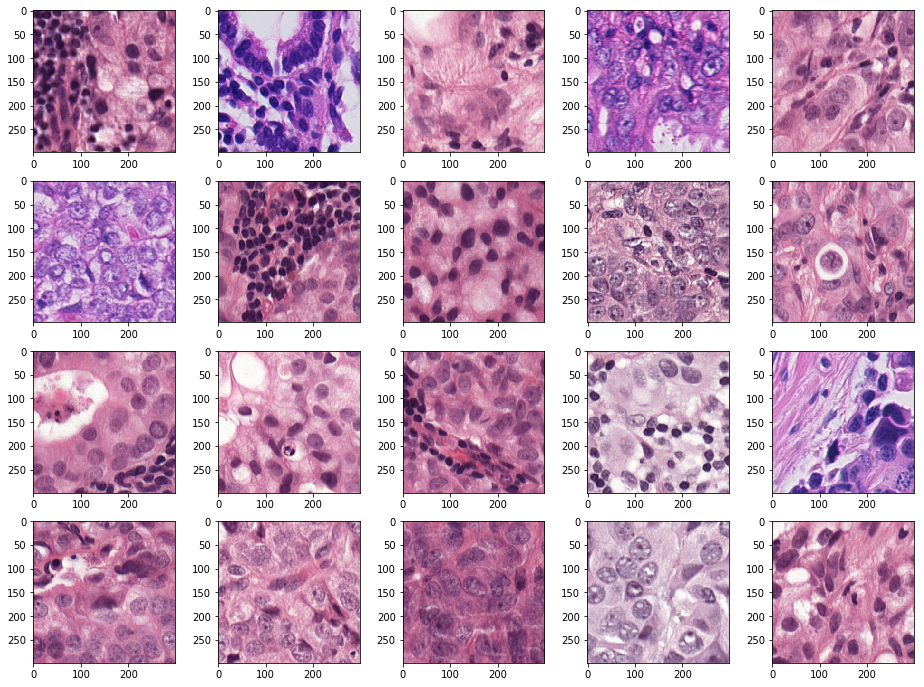

In [12]:
subplots(os.path.join(image_path,'tumor'),random_list)

## After Stain normalization

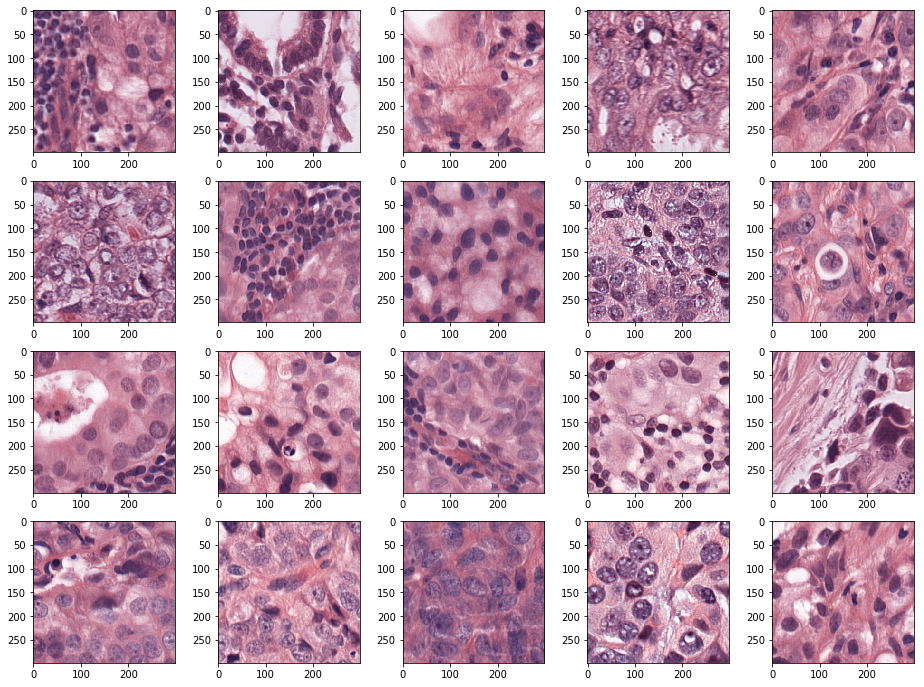

In [13]:
subplots_normal(os.path.join(image_path,'tumor'),random_list)

## 单线程处理

In [ ]:
from tqdm import tqdm
for file in tqdm(tumor_filelist):
    img = cv2.imread(os.path.join(image_path,'tumor',file))
    img = normalize_staining((1,img))
    cv2.imwrite(os.path.join('./input/tumor/',file.replace('training','tumor')),img)
    

 16%|█▌        | 4864/31355 [05:11<28:17, 15.60it/s]

## 多线程处理

In [3]:
import multiprocessing
import sys
def run_tumor(file):
    img = cv2.imread(os.path.join(image_path,'tumor',file))
    img = normalize_staining((1,img))
    cv2.imwrite(os.path.join('./input/tumor/',file.replace('training','tumor')),img)

cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cores)

Process ForkPoolWorker-24:
Process ForkPoolWorker-22:
Process ForkPoolWorker-1:
Process ForkPoolWorker-21:
Process ForkPoolWorker-3:
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Process ForkPoolWorker-19:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-25:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-17:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-26:
Process ForkPoolWorker-16:
Process ForkPoolWorker-20:
Process ForkPoolWorker-8:
Process ForkPoolWorker-23:
Process ForkPoolWorker-9:
Process ForkPoolWorker-18:
Process ForkPoolWorker-27:
Process ForkPoolWorker-29:
Process ForkPoolWorker-7:
Process ForkPoolWorker-15:
Process ForkPoolWorker-28:
Process ForkPoolWorker-30:
Process ForkPoolWorker-32:
Process ForkPoolWorker-31:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Trace

  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in r

  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'run_normal' on <module '__main__'>
AttributeError: Can't get attribute 'run_normal' on <module '__main__'>
AttributeError: Can't get attribute 'run_normal' on <module '__main__'>
AttributeError: Can't get attribute 'run_normal' on <module '__main__'>
AttributeError: Can't get attribute 'run_normal' on <module '__main__'>
AttributeError: Can't get attribute 'run_normal' on <module '__main__'>
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queue

In [5]:

cnt = 0
#pool.imap
for _ in pool.imap_unordered(run_tumor, tumor_filelist):
    sys.stdout.write('done %d/%d\r' % (cnt, len(tumor_filelist)))
    cnt += 1


Process ForkPoolWorker-48:
Process ForkPoolWorker-59:
Process ForkPoolWorker-38:
Process ForkPoolWorker-44:
Process ForkPoolWorker-36:
Process ForkPoolWorker-56:
Process ForkPoolWorker-40:
Process ForkPoolWorker-58:
Process ForkPoolWorker-50:
Process ForkPoolWorker-55:
Process ForkPoolWorker-47:
Process ForkPoolWorker-42:
Process ForkPoolWorker-53:
Process ForkPoolWorker-43:
Traceback (most recent call last):
Process ForkPoolWorker-60:
Process ForkPoolWorker-52:
Process ForkPoolWorker-39:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-46:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-63:
Trace

Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-57:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/

  File "<ipython-input-4-790cafb280ab>", line 97, in normalize_staining
    sats = sats / max_sat * max_sat_ref
KeyboardInterrupt
  File "<ipython-input-4-790cafb280ab>", line 77, in normalize_staining
    extreme_angles = np.array([[np.cos(min_angle), np.cos(max_angle)],[np.sin(min_angle), np.sin(max_angle)]])  # shape (2,2)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1957, in lstsq
    0, work, lwork, iwork, 0)
  File "<ipython-input-4-790cafb280ab>", line 96, in normalize_staining
    max_sat = np.percentile(sats, 99, axis=1, keepdims=True)
Process ForkPoolWorker-61:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call 

KeyboardInterrupt: 

  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py", line 4016, in _ureduce
    r = func(a, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 57, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py", line 4378, in _percentile
    ap.partition(concatenate((indices_below, indices_above)), axis=axis)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "<ipython-input-4-790cafb280ab>", line 92, in normalize_staining
    sats, _, _, _ = np.linalg.lstsq(stains, OD.T)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py", line 4016, in _ureduce
    r = func(a, **kwargs)
Keyboa

  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.r

  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-5-65b209ae3eb3>", line 5, in run_tumor
    img = normalize_staining((1,img))
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-5-65b209ae3eb3>", line 5, in run_tumor
    img = normalize_staining((1,img))
Traceback (most recent call last):
  File "<ipython-input-4-790cafb280ab>", line 52, in normalize_staining
    U, s, V = np.linalg.svd(OD_thresh, full_matrices=False)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "<ipython-input-5-65b209ae3eb3>", line 5, in run_tumor
    img = normalize_staining((1,img))
  Fi

In [4]:
cnt=0
def run_normal(file):
    img = cv2.imread(os.path.join(image_path,'normal',file))
    try:
        
        img = normalize_staining((1,img))
        cv2.imwrite(os.path.join('./input/normal/',file.replace('training','normal')),img)
    except:
        #no normalization
        cv2.imwrite(os.path.join('./input/normal/',file.replace('training','normal')),cv2.imread(os.path.join(image_path,'normal',file)))
for _ in pool.imap_unordered(run_normal, normal_filelist):
    sys.stdout.write('done %d/%d\r' % (cnt, len(normal_filelist)))
    cnt += 1

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: overflow encountered in power


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: overflow encountered in power


Process ForkPoolWorker-57:
Traceback (most recent call last):
Process ForkPoolWorker-53:
Process ForkPoolWorker-52:
Process ForkPoolWorker-60:
Process ForkPoolWorker-51:
Process ForkPoolWorker-47:
Process ForkPoolWorker-55:
Process ForkPoolWorker-45:
Process ForkPoolWorker-64:
Process ForkPoolWorker-48:
Process ForkPoolWorker-49:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-46:
Process ForkPoolWorker-44:
Traceback (most recent call last):
Process ForkPoolWorker-43:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-41:
Process ForkPoolWorker-50:
Process ForkPoolWorker-56:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-59:
Process ForkPoolWorker-42:
Process ForkPoolWork

  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/anaco

  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

KeyboardInterrupt
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._a

KeyboardInterrupt
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
